

<Strong> Develop a TCN model that overfits , then do some regularization , then do some tuning. </Strong>

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , MaxPooling1D
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [18]:
#df_btc = pd.read_csv("../../cryptoData/BTC_1h_data.csv")
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [19]:
# Removing everything but the closing price
btc_data = df_btc.values[:, 4 ,].astype(float)

btc_data[-1]

43534.54

<Strong> Scaling the data  </Strong>

In [20]:
percTrain = 70
percVal = 20 

In [21]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [22]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [23]:
# Using 24 datapoints to predict the 25th

window_length = 24
dilation_rate = 2
kernel_size = 2

features = 1

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [24]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [25]:
btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

print(btc_train[0].shape)

(27370, 24, 1)


In [26]:
# Hyper Parameters that are dependant on the number of layers 

# Dilation_rate
# window_length 
# kernel_size

# The rest of the hyper-parameter

# learning_rate
# Dense layer size
# filters 
# batch_size

<Strong> The number of layers while changing dilation_base , kernel_size or window_size. </Strong>

In [27]:
def getLayers(dilation_rate , window_size , kernel_size):
    
    top = (dilation_rate - 1) * (window_size - 1)
    bottom = (kernel_size - 1) 
    
    division = (top / bottom) + 1 
    log = math.ceil(math.log(division , dilation_rate))
    
    
    # This inequality must hold true for full coverage
    
    first = 1 + (kernel_size - 1)
    second = (dilation_rate ** log ) - 1
    third = dilation_rate - 1
    
    inequality = (second / third) * first
    
    if ( (kernel_size < dilation_rate) or (inequality < window_size) ):
        print("not going to have full coverage")
        return False
    
    else:
        print("layers =" , log , "kernel size =" , kernel_size , "dilation rate =" , dilation_rate )
        return log , dilation_rate , kernel_size


In [28]:
getLayers(4 , 12 , 4)

layers = 2 kernel size = 4 dilation rate = 4


(2, 4, 4)

<Strong> Below I have created 3 models (5 , 4 , 3 layered TCN).  </Strong>

<p> The number for the dilation_rate , kernel_size and window_size for each layer where calculated with the getLayers function above. </p>

<p> Here I am just adjusting necessary componenets. </p>

In [29]:
def createModelFiveLayers(hp):
    
    num_layers = 5
    dilation = 2

    hp_kernel_size = hp.Choice('kernel_size' , values = [2,3,4])
    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006 , 0.008 , 0.01])
    #hp_dense_layer = hp.Choice('dense_layer' , values = [64 , 128 , 256])
    hp_filters = hp.Choice('filters' , values = [32, 64 , 128])
    
    model1 = models.Sequential()
    
    # Casual adds padding to the start of input sequence
    model1.add(Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu', input_shape=(window_length, features), dilation_rate=1 , padding = 'causal'))

    #minus one for the base conv1d layer ^
    for i in range (1 , num_layers):
        
        # For full coverage we need 4 layers 
        model1.add(Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu' , padding = 'causal', dilation_rate= dilation**i))

    #model1.add(Dense(hp_dense_layer, activation='relu'))

    model1.add(Dense(1))

    model1.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model1.compile(optimizer=opt , loss = 'mse')
    
    return model1


In [30]:
tunerFiveLayers = RandomSearch (
    createModelFiveLayers,
    objective = "val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_five_layers'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 24, 32)            96        
                                                                 
 conv1d_6 (Conv1D)           (None, 24, 32)            2080      
                                                                 
 conv1d_7 (Conv1D)           (None, 24, 32)            2080      
                                                                 
 conv1d_8 (Conv1D)           (None, 24, 32)            2080      
                                                                 
 conv1d_9 (Conv1D)           (None, 24, 32)            2080      
                                                                 
 dense_1 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 8,449
Trainable params: 8,449
Non-traina

In [ ]:
tunerFiveLayers.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)])





Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
kernel_size       |2                 |?                 
learning_rate     |0.008             |?                 
filters           |128               |?                 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 128)           384       
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 128)           32896     
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 128)           32896     
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 128)           32896     
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 128)           32896    

In [160]:
def createModelFourLayers(hp):
    
    num_layers = 4
    
    dilation=2
    hp_kernel_size = hp.Choice('kernel_size' , values = [3,4,5])
    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006 , 0.008 , 0.01])
    hp_dense_layer = hp.Choice('dense_layer' , values = [64 , 128 , 256])

    
    model1 = models.Sequential()
    
    # Casual adds padding to the start of input sequence
    model1.add(Conv1D(filters=32, kernel_size=hp_kernel_size, activation='relu', input_shape=(window_length, features), dilation_rate=1 , padding = 'causal'))

    #minus one for the base conv1d layer ^
    for i in range (1 , num_layers):
        
        # For full coverage we need 4 layers 
        model1.add(Conv1D(filters=32, kernel_size=hp_kernel_size, activation='relu' , padding = 'causal', dilation_rate= dilation**i))

    #model1.add(Dense(hp_dense_layer, activation='relu'))

    model1.add(Dense(1))

    model1.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model1.compile(optimizer=opt , loss = 'mse')
    
    return model1
    
    

In [162]:
tunerFourLayers = RandomSearch (
    createModelFourLayers,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_four_layers'
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 24, 32)            128       
                                                                 
 conv1d_9 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 conv1d_10 (Conv1D)          (None, 24, 32)            3104      
                                                                 
 conv1d_11 (Conv1D)          (None, 24, 32)            3104      
                                                                 
 dense_3 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________


In [163]:
tunerFourLayers.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)])


Trial 6 Complete [00h 02m 25s]
val_loss: 0.009956913068890572

Best val_loss So Far: 0.006215453613549471
Total elapsed time: 00h 15m 16s

Search: Running Trial #7

Hyperparameter    |Value             |Best Value So Far 
kernel_size       |3                 |3                 
learning_rate     |0.002             |0.006             
dense_layer       |64                |256               

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 32)            310

KeyboardInterrupt: 

In [247]:
def createModelThreeLayers(hp):
    
    num_layers = 3
    
    hp_dilation_rate = hp.Choice('dilation_rate', values = [2] ) 
    hp_kernel_size = hp.Choice('kernel_size' , values = [3,4,5])
    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006 , 0.008 , 0.01])
    #hp_dense_layer = hp.Choice('dense_layer' , values = [64 , 128 , 256])

    
    model1 = models.Sequential()
    
    # Casual adds padding to the start of input sequence
    model1.add(Conv1D(filters=32, kernel_size=hp_kernel_size, activation='relu', input_shape=(window_length, features), dilation_rate=1 , padding = 'causal'))

    #minus one for the base conv1d layer ^
    for i in range (1 , num_layers):
        
        # For full coverage we need 4 layers 
        model1.add(Conv1D(filters=32, kernel_size=hp_kernel_size, activation='relu' , padding = 'causal', dilation_rate= 2**i))

    #model1.add(Dense(hp_dense_layer, activation='relu'))

    model1.add(Dense(1))

    model1.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model1.compile(optimizer=opt , loss = 'mse')
    
    return model1
    
    

In [248]:
tunerThreeLayers = RandomSearch (
    createModelThreeLayers,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_three_layers'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 32)            128       
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 dense_1 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 6,369
Trainable params: 6,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tunerThreeLayers.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512 , callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)])


Trial 5 Complete [00h 02m 03s]
val_loss: 0.0067231738939881325

Best val_loss So Far: 0.0062348488718271255
Total elapsed time: 00h 09m 30s

Search: Running Trial #6

Hyperparameter    |Value             |Best Value So Far 
dilation_rate     |2                 |2                 
kernel_size       |3                 |4                 
learning_rate     |0.006             |0.004             

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 dense (Dense)               (None, 24, 1)             3

In [102]:
history = model1.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =30 , verbose = 1 ,callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)])



Epoch 1/30
54/54 [==============================] - 3s 47ms/step - loss: 0.0251 - val_loss: 0.2865
Epoch 2/30
54/54 [==============================] - 2s 41ms/step - loss: 0.0011 - val_loss: 0.0555
Epoch 3/30
54/54 [==============================] - 2s 41ms/step - loss: 3.7039e-04 - val_loss: 0.0310
Epoch 4/30
54/54 [==============================] - 2s 42ms/step - loss: 3.2776e-04 - val_loss: 0.0276
Epoch 5/30
54/54 [==============================] - 2s 42ms/step - loss: 3.2388e-04 - val_loss: 0.0206
Epoch 6/30
54/54 [==============================] - 2s 44ms/step - loss: 3.1610e-04 - val_loss: 0.0197
Epoch 7/30
54/54 [==============================] - 2s 42ms/step - loss: 3.0893e-04 - val_loss: 0.0194
Epoch 8/30
54/54 [==============================] - 2s 41ms/step - loss: 3.0680e-04 - val_loss: 0.0202
Epoch 9/30
54/54 [==============================] - 2s 44ms/step - loss: 2.9869e-04 - val_loss: 0.0190
Epoch 10/30
54/54 [==============================] - 2s 42ms/step - loss: 2.9899e

KeyboardInterrupt: 

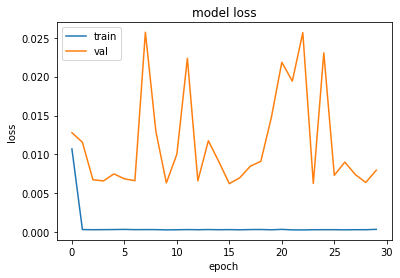

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim([0,0.01])
plt.show()